In [1]:
PATH = "/home/mikehenry/epoxy-stuff/doc_test_enth"

In [10]:
import pandas as pd
import signac
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy.polynomial.polynomial as poly

PA_DEGREE = 6

def mean_squared_error(y_obs, y_pre):
    
    N = len(y_obs)
    # Check same number of samples
    assert N == len(y_pre)
    
    return np.sum((y_obs - y_pre)**2)/N


def make_plots(job_list, path):
    project = signac.get_project(path)
    jobs = project.find_jobs(doc_filter={"cure_percent":{"$gte":80}})
    
    file_path = "../exp_data/Mike_Edits_Janisse_T44_NIR_Concentrations.xlsx"
    sheets = pd.read_excel(file_path, sheet_name=None, skiprows=[0,1], header=None)
    first_sheet = sheets["Sheet6"]
    first_sheet = first_sheet.convert_objects(convert_numeric=True).dropna()
    scale_factor = first_sheet[4].max()

    doc = np.asanyarray(first_sheet[1])/100
    pa = np.asanyarray(first_sheet[4]/scale_factor)
    sa = np.asanyarray(first_sheet[5]/scale_factor)
    
    coefs_sa = poly.polyfit(doc, sa, 6)
    ffit_sa = poly.Polynomial(coefs_sa)
    coefs_pa = poly.polyfit(doc, pa, PA_DEGREE)
    ffit_pa = poly.Polynomial(coefs_pa)
    
    for job in jobs:
        if job._id in job_list:
            try:
                df = pd.read_csv(job.fn("_test_species.log"), delimiter="\t")
            except(FileNotFoundError):
                continue
            print("-----------")
            print(job._id)
            print("R2 FO", job.doc.SAFO_model_R2)
            print("Ea", job.sp.activation_energy)
            print("deltaT", job.sp.deltaT)
            print("sec_bond_weight", job.sp.sec_bond_weight)
            print("% bonds per step" ,job.sp.percent_bonds_per_step)
            print("bond period", job.sp.bond_period)


            cure_fractions = np.asarray(df["#doc"])
            primaryA_cnts = np.asarray(df["primaryA"]) # 0
            secondaryA_cnts = np.asarray(df["secondaryA"]) # 1
            ternaryA_cnts = np.asarray(df["ternaryA"]) # 2 
            quarternaryA_cnts = np.asarray(df["quarternaryA"]) # 3
            fivernaryA_cnts = np.asarray(df["fivernaryA"]) # 4
            scale_factor = primaryA_cnts[0]*2
            primaryA_cnts=primaryA_cnts/scale_factor # 0
            secondaryA_cnts=secondaryA_cnts/scale_factor # 1
            ternaryA_cnts=ternaryA_cnts/scale_factor # 2
            quarternaryA_cnts=quarternaryA_cnts/scale_factor # 3
            fivernaryA_cnts=fivernaryA_cnts/scale_factor # 4

            P_high = primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts
            P_low =  primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts*0

            S_high = secondaryA_cnts + ternaryA_cnts*2 + quarternaryA_cnts
            S_low =  secondaryA_cnts + ternaryA_cnts*0 +quarternaryA_cnts

            T_high = ternaryA_cnts+quarternaryA_cnts+fivernaryA_cnts*2
            T_low = quarternaryA_cnts+fivernaryA_cnts*2

            MSE_P = mean_squared_error(ffit_pa(cure_fractions), P_low)
            MSE_S = mean_squared_error(ffit_sa(cure_fractions), S_low)
            mean_MSE = (MSE_P + MSE_S)/2
            mean_MSEs.append((mean_MSE, job._id))

            print("MSE Primary: ", MSE_P)
            print("MSE Secondary: ", MSE_S)
            print("Mean MSE: ", round(mean_MSE,4))

            plt.figure(dpi=300)

            plt.plot(cure_fractions, P_low, color='#1f77b4', linestyle="--", label="low", marker=".", linewidth=0)
            plt.plot(cure_fractions, S_low, color="#ff7f0e", linestyle="--", marker=".", linewidth=0)


            plt.plot(doc, ffit_pa(doc), color='#1f77b4', linestyle='-', label="exp",)
            plt.plot(doc, ffit_sa(doc), color='#ff7f0e', linestyle='-',)


            primary = mpatches.Patch(color='#1f77b4', label='Primary Amine')
            seconday = mpatches.Patch(color='#ff7f0e', label='Secondary Amine')
            exp = mlines.Line2D([], [], color='grey', linestyle='-', label="Experiment Ref. XX")
            low = mlines.Line2D([], [], color='grey', linestyle='--', label="Simulation")
            
            



            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = OrderedDict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), prop={'size': 15})
            plt.legend(handles=[primary,seconday,exp, low])


            plt.title(str(job._id)+ " RXN Fit:"+ str(round(job.doc.SAFO_model_R2,4)))
            plt.xlabel("Degree of Cure", size=15)
            plt.ylabel("Normalized Concentration", size=15)
            plt.xlim(0,1)
            plt.show()
            
def get_R2s_and_mean_MSEs(path):
    project = signac.get_project(path)
    jobs = project.find_jobs(filter={"bond": True}, doc_filter={"cure_percent":{"$gte":80}})

    file_path = "../exp_data/Mike_Edits_Janisse_T44_NIR_Concentrations.xlsx"
    sheets = pd.read_excel(file_path, sheet_name=None, skiprows=[0,1], header=None)
    first_sheet = sheets["Sheet6"]
    first_sheet = first_sheet.convert_objects(convert_numeric=True).dropna()
    scale_factor = first_sheet[4].max()
    
    doc = np.asanyarray(first_sheet[1])/100
    pa = np.asanyarray(first_sheet[4]/scale_factor)
    sa = np.asanyarray(first_sheet[5]/scale_factor)

    coefs_sa = poly.polyfit(doc, sa, 6)
    ffit_sa = poly.Polynomial(coefs_sa)
    coefs_pa = poly.polyfit(doc, pa, PA_DEGREE)
    ffit_pa = poly.Polynomial(coefs_pa)


    jobs = project.find_jobs(doc_filter={"cure_percent":{"$gte":80}})
    R2s = []
    mean_MSEs = []
    for job in jobs:
        try:
            if job.doc.SAFO_model_R2 is not None:
                df = pd.read_csv(job.fn("_test_species.log"), delimiter="\t")
                R2s.append((job.doc.SAFO_model_R2, job._id))

                cure_fractions = np.asarray(df["#doc"])
                # first we check if there are enough data points
                # we also want to check we have some data points before we reach 50% DOC
                if len(cure_fractions) > 5 and (np.count_nonzero(cure_fractions < .5)) > 2:
                    #print(np.count_nonzero(cure_fractions < .5))
                    # two points less than 50% not zero 


                    primaryA_cnts = np.asarray(df["primaryA"]) # 0
                    secondaryA_cnts = np.asarray(df["secondaryA"]) # 1
                    ternaryA_cnts = np.asarray(df["ternaryA"]) # 2 
                    quarternaryA_cnts = np.asarray(df["quarternaryA"]) # 3
                    fivernaryA_cnts = np.asarray(df["fivernaryA"]) # 4
                    scale_factor = primaryA_cnts[0]*2
                    primaryA_cnts=primaryA_cnts/scale_factor # 0
                    secondaryA_cnts=secondaryA_cnts/scale_factor # 1
                    ternaryA_cnts=ternaryA_cnts/scale_factor # 2
                    quarternaryA_cnts=quarternaryA_cnts/scale_factor # 3
                    fivernaryA_cnts=fivernaryA_cnts/scale_factor # 4

                    P_low =  primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts*0
                    S_low =  secondaryA_cnts + ternaryA_cnts*0 +quarternaryA_cnts

                    MSE_P = mean_squared_error(ffit_pa(cure_fractions), P_low)
                    MSE_S = mean_squared_error(ffit_sa(cure_fractions), S_low)
                    mean_MSE = (MSE_P + MSE_S)/2

                    mean_MSEs.append((mean_MSE, job._id))
        except(AttributeError, FileNotFoundError):
            continue
    return R2s, mean_MSEs 

/home/mikehenry/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/ipykernel_launcher.py:127: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


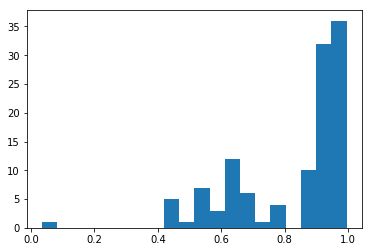

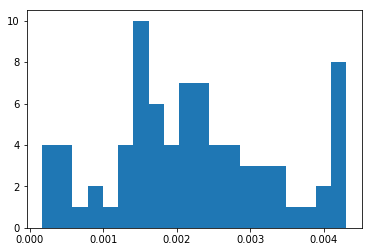

['007e9f67a1e2008a7490c74f5d3d4c77', 'ffc9761e3a93e6d5fc23e0d45b9dc0b7', 'db95708e1aadaa6a1f292f1bedf6b936', '7f986b723a0c65a46939eb9f97e15479', '455a7f06920d647ba50059c9d4a628c6', 'b94c2cbd576486d324ec872700958fe5', '90d8a486545e497adf0da9cd6312dcdd', 'c91bbdb7656a5115151c6c4ca581d309', '5241852dcd1a9e9f9a79753ca3757b3b', 'ef1f223775135a4c5362f8e805a33d3d', 'fd08c592d9b56443df7f7bb65ac92d75', '9836eca99d24c43f926d8fe04ba39141', '75492369a6b72d1a5857e80fc0102496', 'bae096c6f230fb3afd249e690334e209', '7df159912da8a936a6ccca464a73ac5d', 'a2b98bdc5efecc780786c3b49e11ea41', '185c4b61138e022de384dc7e2807d7b2', '746472de5e6d55a1a9143590f71a59f4', '6daa1256ba6e38def384824187ea1e50', 'fea28d9f7b7fc3b0fecfdaa29ab7114a']
['fea28d9f7b7fc3b0fecfdaa29ab7114a', '6daa1256ba6e38def384824187ea1e50', '9836eca99d24c43f926d8fe04ba39141', 'b94c2cbd576486d324ec872700958fe5']


/home/mikehenry/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


-----------
9836eca99d24c43f926d8fe04ba39141
R2 FO 0.9940332533820595
Ea 5.0
deltaT 1e-05
sec_bond_weight 1.0
% bonds per step 0.1
bond period 100
MSE Primary:  0.0009123418260566275
MSE Secondary:  0.0005828545567407308
Mean MSE:  0.0007


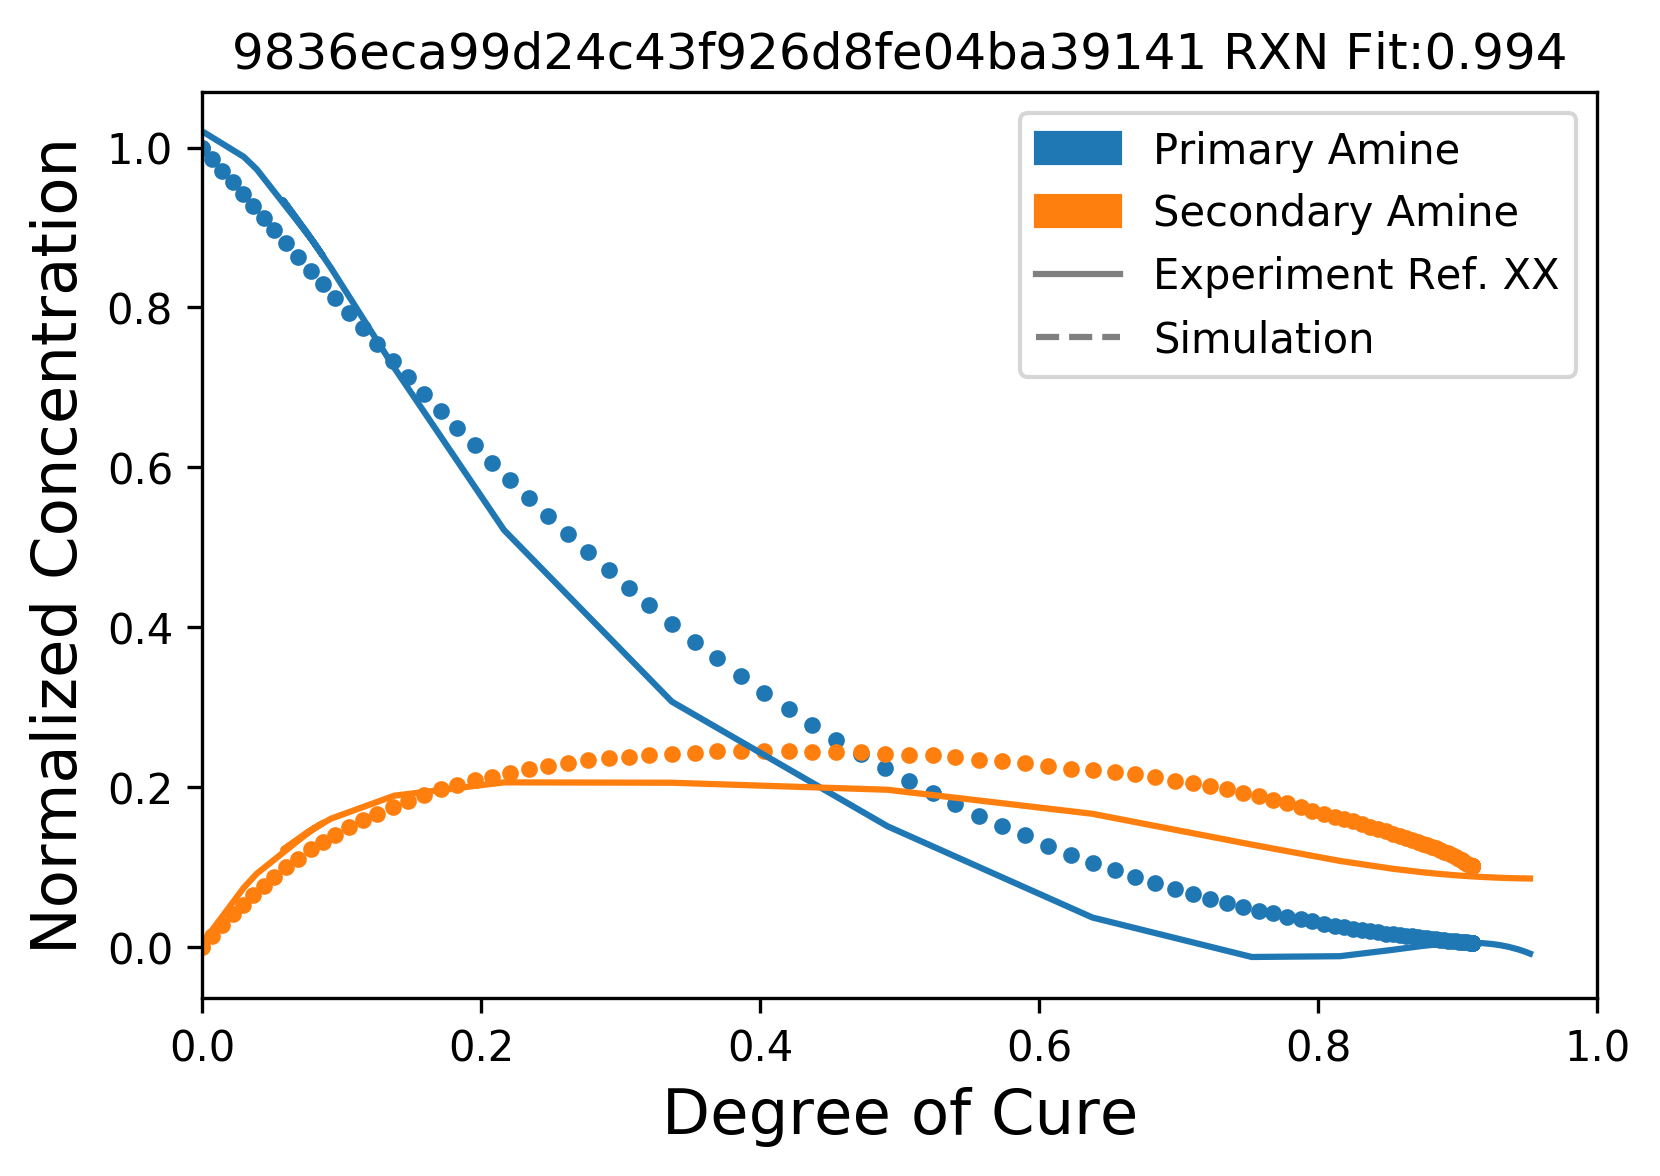

-----------
b94c2cbd576486d324ec872700958fe5
R2 FO 0.9843517214177486
Ea 2.0
deltaT 1e-05
sec_bond_weight 1.0
% bonds per step 0.01
bond period 100
MSE Primary:  0.0015320013983013167
MSE Secondary:  0.000985063206938267
Mean MSE:  0.0013


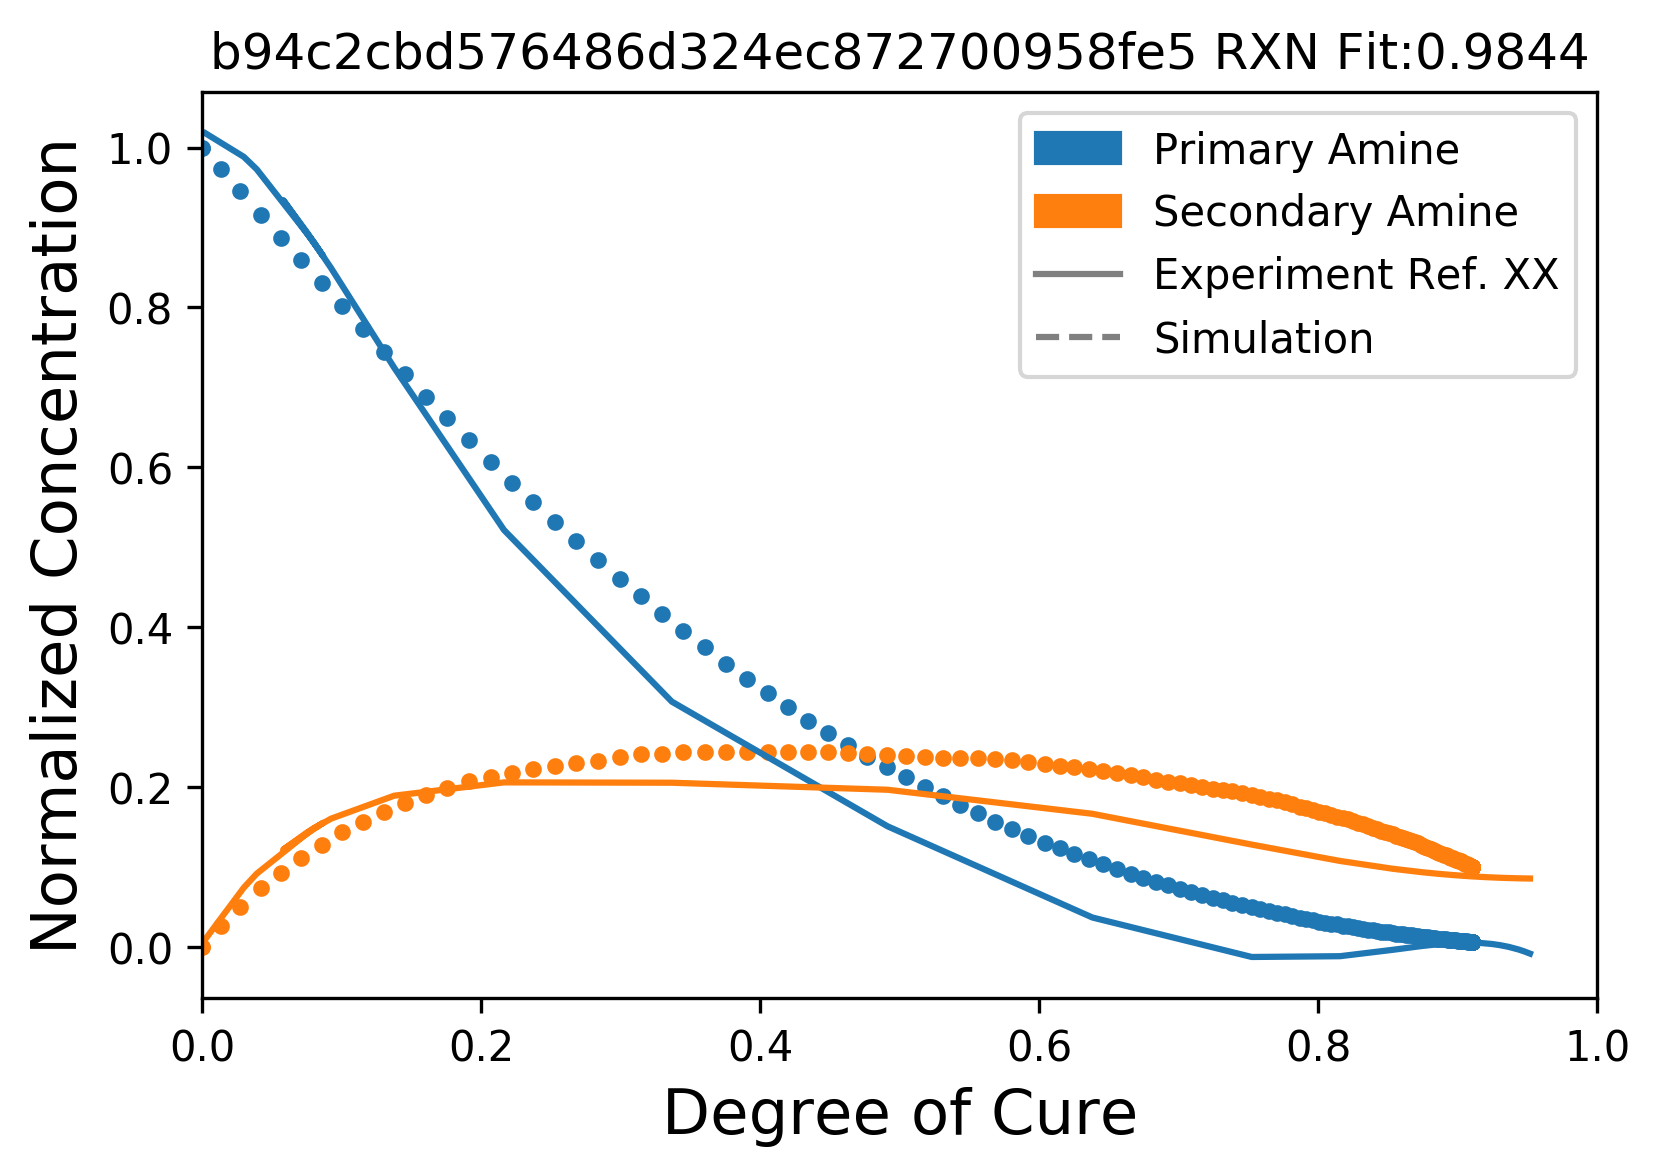

-----------
6daa1256ba6e38def384824187ea1e50
R2 FO 0.9943920672483405
Ea 5.0
deltaT 1e-05
sec_bond_weight 1.0
% bonds per step 1.0
bond period 100
MSE Primary:  0.0001672188367933464
MSE Secondary:  0.00024432235722406836
Mean MSE:  0.0002


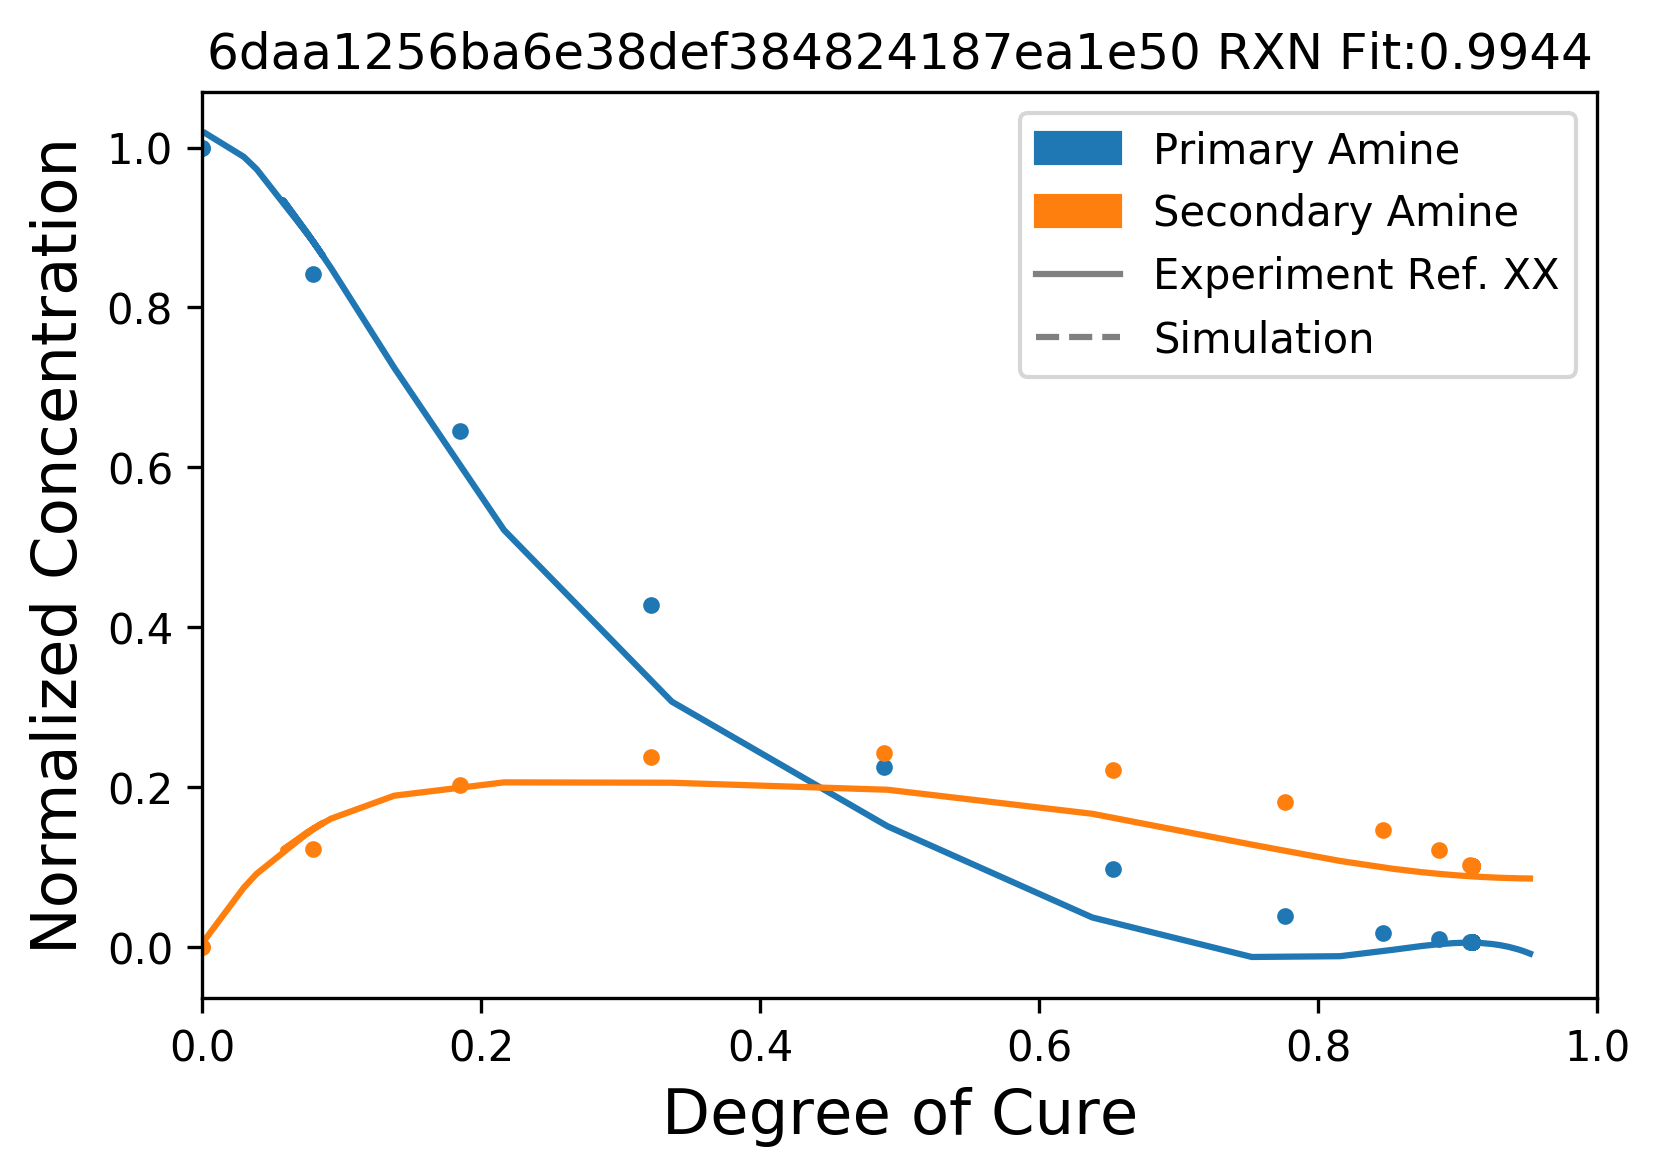

-----------
fea28d9f7b7fc3b0fecfdaa29ab7114a
R2 FO 0.9861973062435614
Ea 2.0
deltaT 1e-05
sec_bond_weight 1.0
% bonds per step 0.1
bond period 100
MSE Primary:  0.00010707088077867144
MSE Secondary:  0.00023059267025169302
Mean MSE:  0.0002


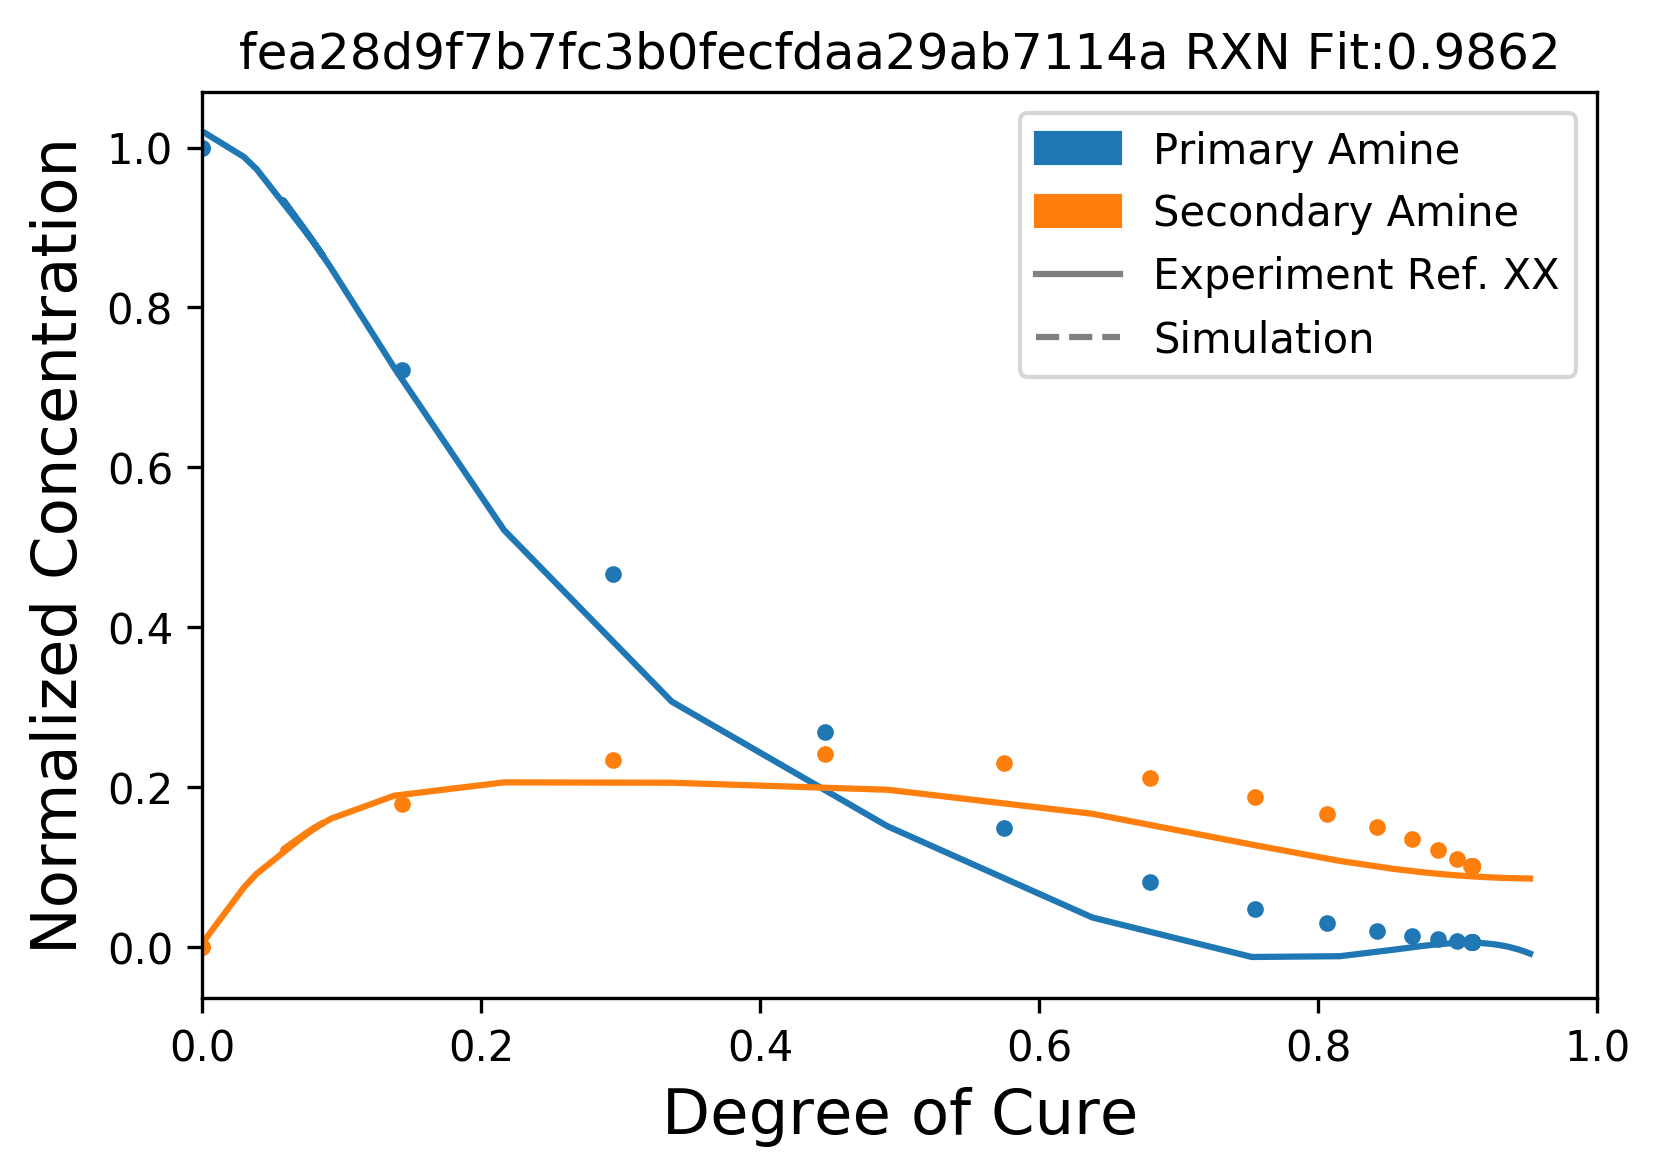

In [12]:
path = "/home/mikehenry/epoxy-stuff/doc_test_enth"

R2s, mean_MSEs = get_R2s_and_mean_MSEs(path)

plt.hist([_[0] for _ in R2s if _[0] > 0], bins=20)
plt.show()
plt.hist([_[0] for _ in mean_MSEs], bins=20)
plt.show()
top_ten = [_[1] for _ in sorted(R2s)[-20:]]
top_ten_MSE = [_[1] for _ in sorted(mean_MSEs, reverse=True)[-20:]]

both = list(set(top_ten_MSE) & set(top_ten))
print(top_ten_MSE)
print(both)
make_plots(both, path)